**Hey, guys. In this notebook, I will employ CNN to establish my preliminary model, followed by the utilization of transfer learning to construct the ultimate model. Throughout the process of employing transfer learning, I continuously fine-tuned and experimented with various pretrained models. I have diligently documented my contemplative journey, with the aspiration that it may also serve to stimulate your own reflections.**
> Here's the outline:
1. [Import Library](#part1)
2. [Explore the Data](#part2)
3. [Create CNN model](#part3)
4. [Transfer Learning](#part4)
5. [Evaluate Final Model](#part5)

<a id="part1"></a>
## Import Library
import necessary library

In [9]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from PIL import Image
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B0, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix

<a id="part2"></a>
## Explore the data
First, we need to establish a dictionary to store data variables, facilitating their subsequent utilization.  
Then, Let us randomly take a look at these images.

In [3]:
# create speicific train and test dict
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

train_dict = {}
test_dict = {}
for i in os.listdir(train_path):
    train_dict[i] = os.path.join(train_path, i)
for i in os.listdir(test_path):
    test_dict[i] = os.path.join(test_path, i)

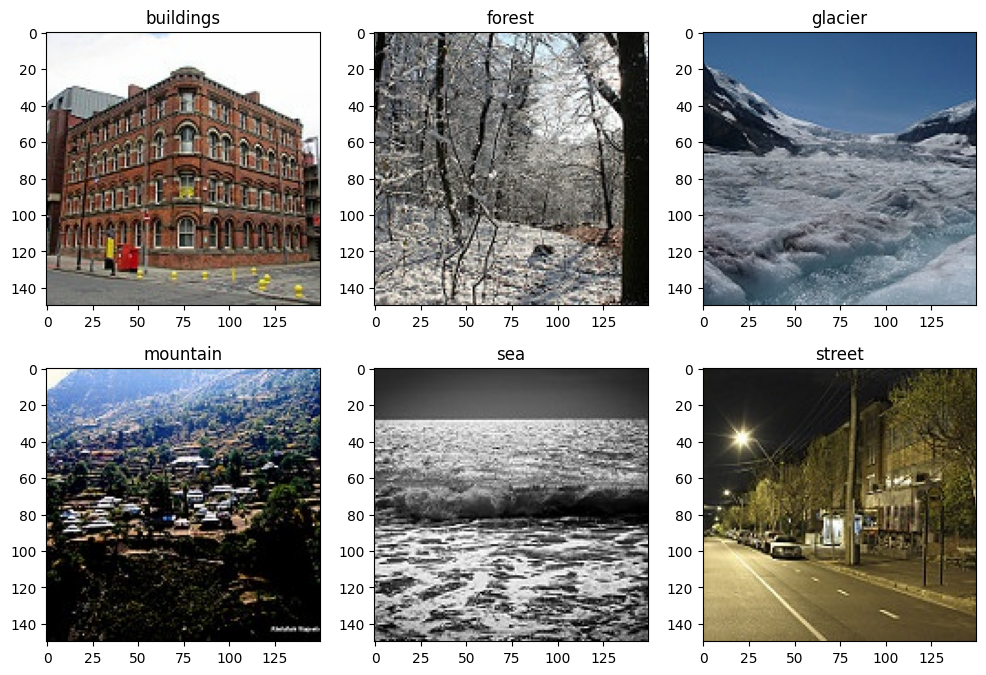

In [3]:
# look up data
def show_image(ax, image):
    img_paths = glob.glob(f"{train_path}{image}/*")
    i = np.random.randint(len(img_paths))
    img = Image.open(img_paths[i])
    ax.imshow(img)
    ax.set_title(image)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
image_categories = list(train_dict.keys())
show_image(ax[0, 0], 'buildings')
show_image(ax[0, 1], 'forest')
show_image(ax[0, 2], 'glacier')
show_image(ax[1, 0], 'mountain')
show_image(ax[1, 1], 'sea')
show_image(ax[1, 2], 'street')

**It's really important to know the shape of the image. As you can see, Most of the images are (150,150,3)**

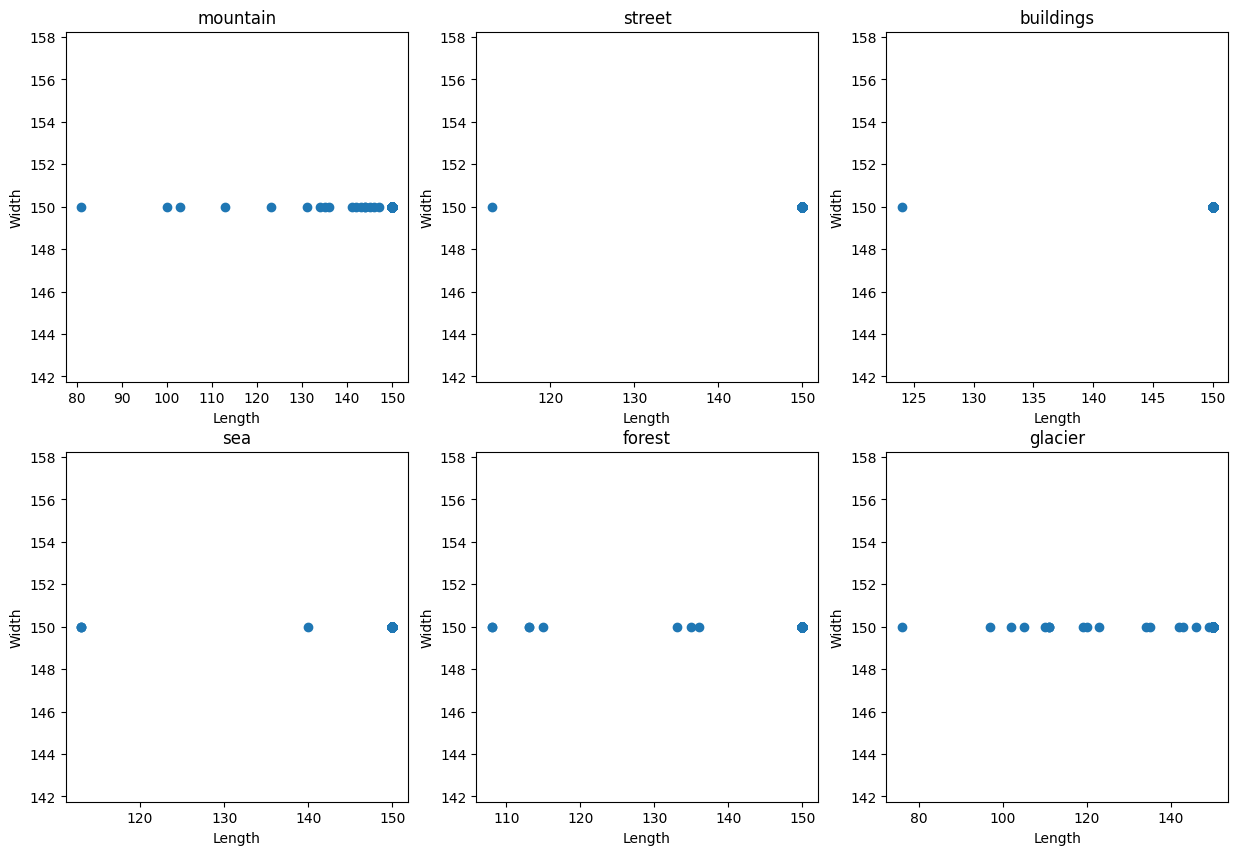

In [3]:
def plot_shape(image, ax):
    dim1 = []
    dim2 = []
    for image_filename in os.listdir(train_dict[image]):
        img = imread(train_dict[image]+'/'+image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
    ax.scatter(dim1, dim2)
    ax.set_title(image)
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
image_categories = list(train_dict.keys())
plot_shape(image_categories[0], axes[0, 0])
plot_shape(image_categories[1], axes[0, 1])
plot_shape(image_categories[2], axes[0, 2])
plot_shape(image_categories[3], axes[1, 0])
plot_shape(image_categories[4], axes[1, 1])
plot_shape(image_categories[5], axes[1, 2])

**Creating an image generator is crucial; this can help us reduce the likelihood of overfitting.**

In [38]:
# image augmented
image_shape = (150,150,3)
batch_size = 64
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
train_gen.class_indices

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

<a id="part3"></a>
## Create CNN model
Now, we can create our CNN model. Since we will use a pretrained model later, so I won't make any adjustments to the layers or optimizer at this point.  

In [6]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
439/439 [==============================] - 135s 283ms/step - loss: 1.3080 - accuracy: 0.5503 - val_loss: 0.9359 - val_accuracy: 0.6517
Epoch 2/20
439/439 [==============================] - 109s 248ms/step - loss: 0.9299 - accuracy: 0.6461 - val_loss: 0.8616 - val_accuracy: 0.6737
Epoch 3/20
439/439 [==============================] - 108s 247ms/step - loss: 0.8424 - accuracy: 0.6846 - val_loss: 0.8352 - val_accuracy: 0.6883
Epoch 4/20
439/439 [==============================] - 108s 246ms/step - loss: 0.7841 - accuracy: 0.7191 - val_loss: 0.7467 - val_accuracy: 0.7203
Epoch 5/20
439/439 [==============================] - 108s 246ms/step - loss: 0.7348 - accuracy: 0.7304 - val_loss: 0.7366 - val_accuracy: 0.7497
Epoch 6/20
439/439 [==============================] - 106s 241ms/step - loss: 0.6939 - accuracy: 0.7532 - val_loss: 0.6795 - val_accuracy: 0.7620
Epoch 7/20
439/439 [==============================] - 109s 249ms/step - loss: 0.6688 - accuracy: 0.7625 - val_loss: 0.6326 -

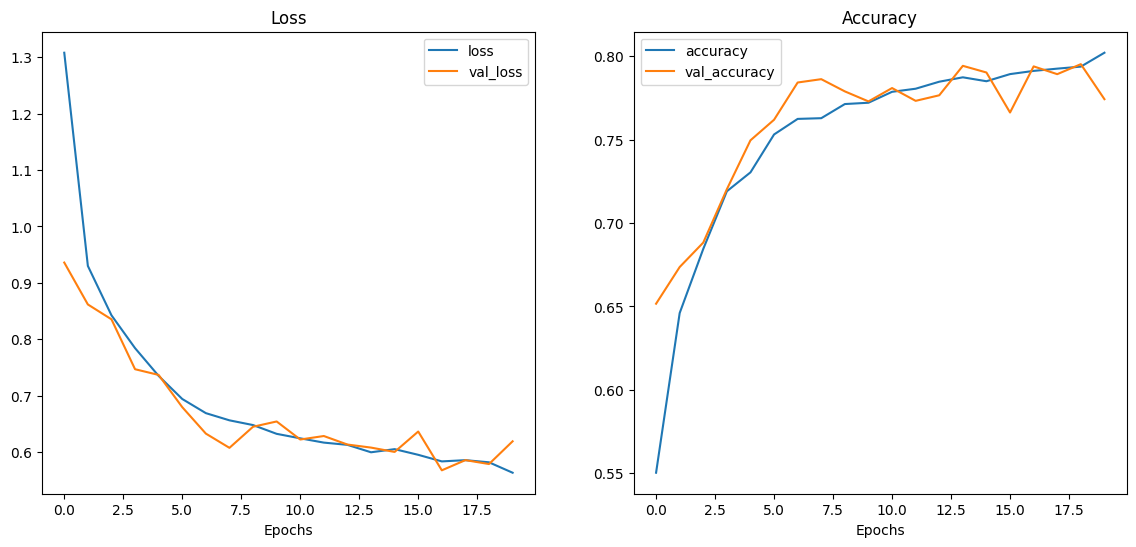

In [14]:
# plot the results
fig, ax = plt.subplots(1,2, figsize=(14,6))
pd.DataFrame(model.history.history)[['loss','val_loss']].plot(ax = ax[0])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot(ax = ax[1])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs');

In [17]:
# evaluate model
loss, accuracy = model.evaluate(test_gen)

94/94 [==============================] - 19s 205ms/step - loss: 0.6158 - accuracy: 0.7783


**The results look good, with a simple CNN model achieving an accuracy of 0.78.**  
Next, let's adjust the batch size to see if we can improve the accuracy.

In [24]:
# with batch_size = 128
image_shape = (150,150,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Epoch 1/20
110/110 [==============================] - 114s 1s/step - loss: 0.4955 - accuracy: 0.8252 - val_loss: 0.5046 - val_accuracy: 0.8257
Epoch 2/20
110/110 [==============================] - 112s 1s/step - loss: 0.4813 - accuracy: 0.8320 - val_loss: 0.4973 - val_accuracy: 0.8213
Epoch 3/20
110/110 [==============================] - 113s 1s/step - loss: 0.4838 - accuracy: 0.8323 - val_loss: 0.5378 - val_accuracy: 0.8090
Epoch 4/20
110/110 [==============================] - 114s 1s/step - loss: 0.4889 - accuracy: 0.8276 - val_loss: 0.5046 - val_accuracy: 0.8137
Epoch 5/20
110/110 [==============================] - 113s 1s/step - loss: 0.4783 - accuracy: 0.8292 - val_loss: 0.5123 - val_accuracy: 0.8217
Epoch 6/20
110/110 [==============================] - 113s 1s/step - loss: 0.4726 - accuracy: 0.8319 - val_loss: 0.5044 - val_accuracy: 0.8260
Epoch 7/20
110/110 [==============================] - 110s 1s/step - loss: 0.4694 - accuracy: 0.8344 - val_loss: 0.4978 - val_accuracy: 0.8277

<Axes: >

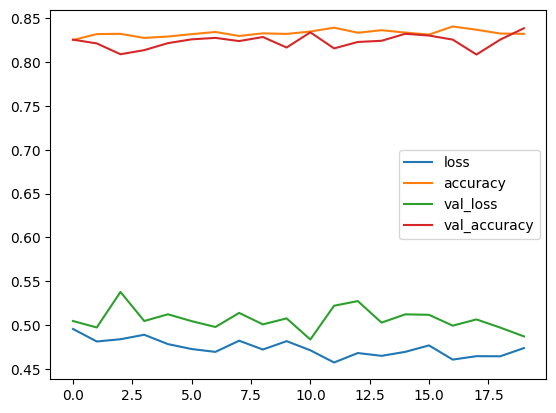

In [25]:
pd.DataFrame(model.history.history).plot()

In [27]:
loss, accuracy = model.evaluate(test_gen)

24/24 [==============================] - 19s 805ms/step - loss: 0.5105 - accuracy: 0.8210


**Not Bad! We improve our accuracy to 0.82**

<a id="part4"></a>
## Transfer Learning
Now, we can use transfer learning to improve our model.
First of all, Let's try VGG16. Since the input layer of VGG16 has a size of 224, so we need to adjust the size of our images accordingly.

In [31]:
# try vgg16
# reshape image size
image_shape = (224,224,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
train_gen.class_indices

base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
base_model.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/20
110/110 [==============================] - 276s 2s/step - loss: 0.6851 - accuracy: 0.7674 - val_loss: 0.4360 - val_accuracy: 0.8453
Epoch 2/20
110/110 [==============================] - 250s 2s/step - loss: 0.4069 - accuracy: 0.8512 - val_loss: 0.4690 - val_accuracy: 0.8307
Epoch 3/20
110/110 [==============================] - 241s 2s/step - loss: 0.3676 - accuracy: 0.8652 - val_loss: 0.3996 - val_accuracy: 0.8513
Epoch 4/20
110/110 [==============================] - 240s 2s/step - loss: 0.3461 - accuracy: 0.8720 - val_loss: 0.3641 - val_accuracy: 0.8690
Epoch 5/20
110/110 [==============================] - 241s 2s/step - loss: 0.3367 - accuracy: 0.8754 - val_loss: 0.3800 - val_accuracy: 0.8630
Epoch 6/20
110/110 [==============================] - 238s 2s/step - loss: 0.3103 - accuracy: 0.8853 - val_loss: 0.3701 - val_accuracy: 0.8683
Epoch 7/20
110/110 [==============================] - 240

<Axes: >

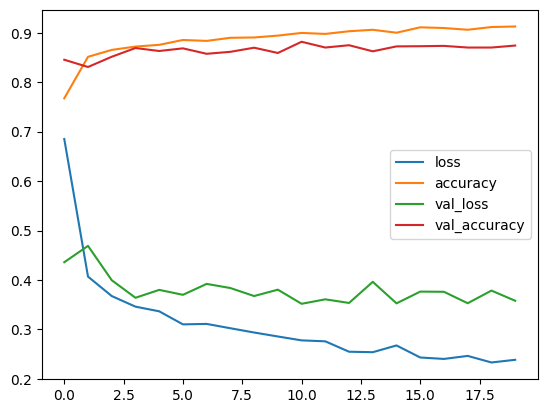

In [32]:
pd.DataFrame(model.history.history).plot()

In [33]:
loss, accuracy = model.evaluate(test_gen)

24/24 [==============================] - 41s 2s/step - loss: 0.3583 - accuracy: 0.8733


**It's insane that we improve our model accuracy to 0.87**  
Then, I changed the batch size to see if it can improve the performance.

In [35]:
# try vgg16
# reshape image size and change batch size to 64
image_shape = (224,224,3)
batch_size = 64
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
train_gen.class_indices

base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
base_model.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/20
220/220 [==============================] - 254s 1s/step - loss: 0.6686 - accuracy: 0.7805 - val_loss: 0.4236 - val_accuracy: 0.8460
Epoch 2/20
220/220 [==============================] - 241s 1s/step - loss: 0.4105 - accuracy: 0.8461 - val_loss: 0.4118 - val_accuracy: 0.8507
Epoch 3/20
220/220 [==============================] - 238s 1s/step - loss: 0.3756 - accuracy: 0.8610 - val_loss: 0.4139 - val_accuracy: 0.8470
Epoch 4/20
220/220 [==============================] - 234s 1s/step - loss: 0.3348 - accuracy: 0.8750 - val_loss: 0.3907 - val_accuracy: 0.8523
Epoch 5/20
220/220 [==============================] - 233s 1s/step - loss: 0.3248 - accuracy: 0.8835 - val_loss: 0.3798 - val_accuracy: 0.8647
Epoch 6/20
220/220 [==============================] - 235s 1s/step - loss: 0.3177 - accuracy: 0.8849 - val_loss: 0.3507 - val_accuracy: 0.8643
Epoch 7/20
220/220 [==============================] - 235

<Axes: >

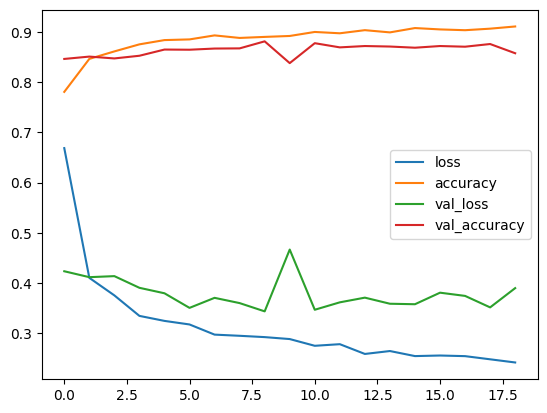

In [36]:
pd.DataFrame(model.history.history).plot()

In [37]:
loss, accuracy = model.evaluate(test_gen)

47/47 [==============================] - 44s 935ms/step - loss: 0.3829 - accuracy: 0.8607


**It seems that the adjustments didn't make a significant difference.**  
Then we try ResNet. This model typically performs well in deeper networks. They are usually better suited for larger and more complex datasets, but with 14,000 images, it might be worth trying.

In [55]:
# try ResNet
res = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)

for layer in res.layers[:-4]:#val_accuracy: 0.3773
    layer.trainable = False
x = res.output
#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.1)(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=res.input, outputs=output)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Epoch 1/20
220/220 [==============================] - 122s 537ms/step - loss: 1.2010 - accuracy: 0.5035 - val_loss: 1.8044 - val_accuracy: 0.3287
Epoch 2/20
220/220 [==============================] - 116s 526ms/step - loss: 1.0796 - accuracy: 0.5641 - val_loss: 1.2347 - val_accuracy: 0.4933
Epoch 3/20
220/220 [==============================] - 118s 534ms/step - loss: 1.0440 - accuracy: 0.5815 - val_loss: 1.2266 - val_accuracy: 0.5053
Epoch 4/20
220/220 [==============================] - 116s 527ms/step - loss: 1.0217 - accuracy: 0.5950 - val_loss: 1.1656 - val_accuracy: 0.5390
Epoch 5/20
220/220 [==============================] - 117s 534ms/step - loss: 0.9959 - accuracy: 0.6030 - val_loss: 1.2593 - val_accuracy: 0.5007
Epoch 6/20
220/220 [==============================] - 118s 536ms/step - loss: 0.9890 - accuracy: 0.6077 - val_loss: 1.0213 - val_accuracy: 0.5740
Epoch 7/20
220/220 [==============================] - 117s 534ms/step - loss: 0.9764 - accuracy: 0.6145 - val_loss: 1.0308 -

**Apparently, it's note quite good.**  
Then we try EfficientNet. This is a relatively new model, and we start from the smallest one.

In [18]:
# try efficientNet B0
# reshape
image_shape = (224,224,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
# create pretrained model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=image_shape)
for layer in base_model.layers[:-15]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/20


2023-09-12 13:33:44.997740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 222s 2s/step - loss: 1.7682 - accuracy: 0.2160 - val_loss: 1.7010 - val_accuracy: 0.2600
Epoch 2/20
110/110 [==============================] - 211s 2s/step - loss: 1.7139 - accuracy: 0.2433 - val_loss: 1.7079 - val_accuracy: 0.2150
Epoch 3/20
110/110 [==============================] - 209s 2s/step - loss: 1.6783 - accuracy: 0.2614 - val_loss: 1.6134 - val_accuracy: 0.3347
Epoch 4/20
110/110 [==============================] - 210s 2s/step - loss: 1.6484 - accuracy: 0.2726 - val_loss: 1.6755 - val_accuracy: 0.2393
Epoch 5/20
110/110 [==============================] - 209s 2s/step - loss: 1.6362 - accuracy: 0.2708 - val_loss: 1.6456 - val_accuracy: 0.2690
Epoch 6/20
110/110 [==============================] - 207s 2s/step - loss: 1.6170 - accuracy: 0.2901 - val_loss: 1.5486 - val_accuracy: 0.3133
Epoch 7/20
110/110 [==============================] - 209s 2s/step - loss: 1.6046 - accuracy: 0.2949 - val_loss: 1.5923 - val_accuracy: 0.2503
Epoch 8/20

<Axes: >

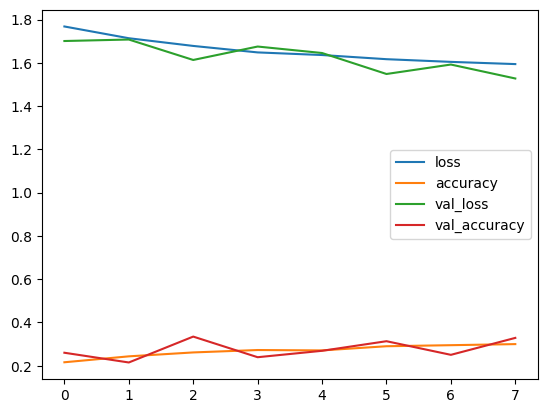

In [19]:
pd.DataFrame(model.history.history).plot()

**Looks like the model can't achieving effective learning.**  
After testing, it seems that more basic or lightweight models perform better. This time, we'll switch to using MobileNet.

In [22]:
# try MobileNet
image_shape = (224,224,3)
batch_size = 64
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')

mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
mobile.trainable = False

x = mobile.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/20
220/220 [==============================] - 215s 954ms/step - loss: 0.8595 - accuracy: 0.8145 - val_loss: 0.4218 - val_accuracy: 0.8603
Epoch 2/20
220/220 [==============================] - 212s 963ms/step - loss: 0.4056 - accuracy: 0.8702 - val_loss: 0.3990 - val_accuracy: 0.8567
Epoch 3/20
220/220 [==============================] - 206s 939ms/step - loss: 0.3728 - accuracy: 0.8777 - val_loss: 0.3719 - val_accuracy: 0.8763
Epoch 4/20
220/220 [==============================] - 208s 944ms/step - loss: 0.3297 - accuracy: 0.8894 - val_loss: 0.3594 - val_accuracy: 0.8823
Epoch 5/20
220/220 [==============================] - 209s 953ms/step - loss: 0.3090 - accuracy: 0.8940 - val_loss: 0.4098 - val_accuracy: 0.8757
Epoch 6/20
220/220 [==============================] - 207s 944ms/step - loss: 0.2774 - accuracy: 0.9032 - val_loss: 0.3415 - val_accuracy: 0.8857
Epoch 7/20
220/220 [===================

<Axes: >

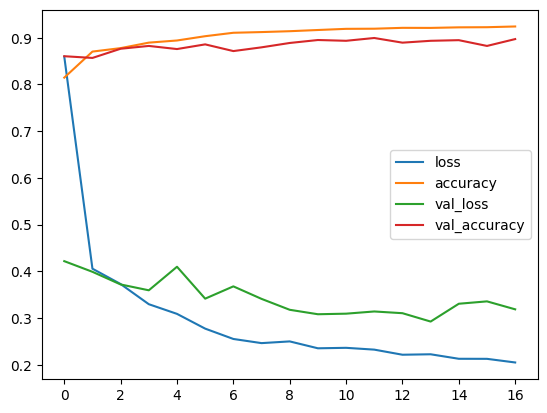

In [23]:
pd.DataFrame(model.history.history).plot()

In [24]:
loss, accuracy = model.evaluate(test_gen)

47/47 [==============================] - 37s 781ms/step - loss: 0.3281 - accuracy: 0.8877


**Not Bad!! Its performance is greater than VGG16**  
we can Try different combinations to adjust the model's performance is a good strategy. Keep experimenting to find the best configuration. 
First, adjusting the learning rate and batch size is a wise move. It appears that the model's stability has improved as a result.

In [3]:
# try MobileNet
image_shape = (224,224,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')

mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
mobile.trainable = False

x = mobile.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
110/110 [==============================] - 703s 6s/step - loss: 0.4840 - accuracy: 0.8275 - val_loss: 0.3537 - val_accuracy: 0.8750
Epoch 2/20
110/110 [==============================] - 654s 6s/step - loss: 0.3095 - accuracy: 0.8871 - val_loss: 0.3024 - val_accuracy: 0.8823
Epoch 3/20
110/110 [==============================] - 644s 6s/step - loss: 0.2739 - accuracy: 0.8983 - val_loss: 0.3096 - val_accuracy: 0.8890
Epoch 4/20
110/110 [==============================] - 643s 6s/step - loss: 0.2562 - accuracy: 0.9037 - val_loss: 0.2880 - val_accuracy: 0.8950
Epoch 5/20
110/110 [==============================] - 664s 6s/step - loss: 0.2509 - accuracy: 0.9059 - val_loss: 0.2934 - val_accuracy: 0.8870
Epoch 6/20
110/110 [==============================] - 637s 6s/step - loss: 0.2314 - accuracy: 0.9128 - val_loss: 0.2928 - val_accuracy: 0

**Next, we are experimenting with changing the dense layer to Global Average Pooling (GAP).**

In [6]:
# try MobileNet
image_shape = (224,224,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')

mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
mobile.trainable = False

x = mobile.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/20
110/110 [==============================] - 655s 6s/step - loss: 1.0087 - accuracy: 0.6374 - val_loss: 0.5704 - val_accuracy: 0.8157
Epoch 2/20
110/110 [==============================] - 641s 6s/step - loss: 0.4867 - accuracy: 0.8407 - val_loss: 0.4501 - val_accuracy: 0.8390
Epoch 3/20
110/110 [==============================] - 637s 6s/step - loss: 0.4036 - accuracy: 0.8592 - val_loss: 0.4050 - val_accuracy: 0.8577
Epoch 4/20
110/110 [==============================] - 607s 6s/step - loss: 0.3730 - accuracy: 0.8686 - val_loss: 0.3749 - val_accuracy: 0.8710
Epoch 5/20
110/110 [==============================] - 640s 6s/step - loss: 0.3564 - accuracy: 0.8740 - val_loss: 0.3534 - val_accuracy: 0.8700
Epoch 6/20
110/110 [==============================] - 637s 6s/step - loss: 0.3377 - accuracy: 0.8775 - val_loss: 0.3492 - val_accuracy: 0

<Axes: >

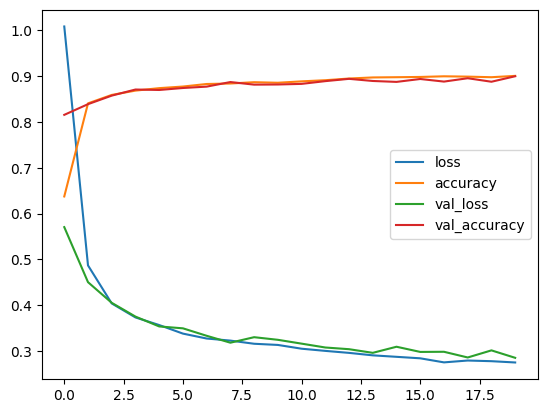

In [7]:
pd.DataFrame(model.history.history).plot()

**We can find accuracy get improved.**  
Then, we'll try unfreezing some layers to see how it affects the performance.

In [4]:
# unfreeze some layers
# try MobileNet
image_shape = (224,224,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')

mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
for layer in mobile.layers[:-4]:
    layer.trainable = False

x = mobile.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/20
110/110 [==============================] - 328s 3s/step - loss: 0.4090 - accuracy: 0.8497 - val_loss: 0.4332 - val_accuracy: 0.8377
Epoch 2/20
110/110 [==============================] - 217s 2s/step - loss: 0.2735 - accuracy: 0.8997 - val_loss: 0.4801 - val_accuracy: 0.8290
Epoch 3/20
110/110 [==============================] - 217s 2s/step - loss: 0.2444 - accuracy: 0.9096 - val_loss: 0.3623 - val_accuracy: 0.8677
Epoch 4/20
110/110 [==============================] - 217s 2s/step - loss: 0.2218 - accuracy: 0.9191 - val_loss: 0.3324 - val_accuracy: 0.8733
Epoch 5/20
110/110 [==============================] - 221s 2s/step - loss: 0.2092 - accuracy: 0.9220 - val_loss: 0.3447 - val_accuracy: 0.8717
Epoch 6/20
110/110 [==============================] - 222s 2s/step - loss: 0.1954 - accuracy: 0.9292 - val_loss: 0.2974 - val_accuracy: 0

<Axes: >

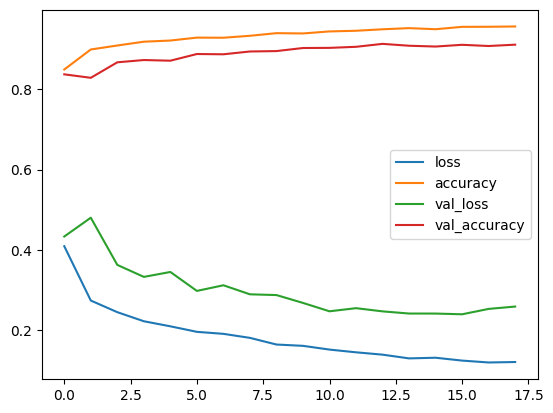

In [5]:
pd.DataFrame(model.history.history).plot()

In [6]:
loss, accuracy = model.evaluate(test_gen)

24/24 [==============================] - 36s 2s/step - loss: 0.2472 - accuracy: 0.9130


In [4]:
image_shape = (224,224,3)
batch_size = 128
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen = datagen.flow_from_directory(train_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
test_gen = datagen.flow_from_directory(test_path, target_size=image_shape[:2],
                                        color_mode='rgb', batch_size=batch_size, class_mode='categorical')
mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
for layer in mobile.layers[:-4]:
    layer.trainable = False

x = mobile.output
#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(6, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics='accuracy')
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=[es])

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/20
110/110 [==============================] - 401s 4s/step - loss: 0.4076 - accuracy: 0.8556 - val_loss: 0.4130 - val_accuracy: 0.8610
Epoch 2/20
110/110 [==============================] - 357s 3s/step - loss: 0.2839 - accuracy: 0.8975 - val_loss: 0.3716 - val_accuracy: 0.8640
Epoch 3/20
110/110 [==============================] - 352s 3s/step - loss: 0.2529 - accuracy: 0.9084 - val_loss: 0.3566 - val_accuracy: 0.8727
Epoch 4/20
110/110 [==============================] - 353s 3s/step - loss: 0.2253 - accuracy: 0.9173 - val_loss: 0.3194 - val_accuracy: 0.8843
Epoch 5/20
110/110 [==============================] - 349s 3s/step - loss: 0.2063 - accuracy: 0.9247 - val_loss: 0.3131 - val_accuracy: 0.8837
Epoch 6/20
110/110 [==============================] - 341s 3s/step - loss: 0.1950 - accuracy: 0.9293 - val_loss: 0.3087 - val_accuracy: 0

<Axes: >

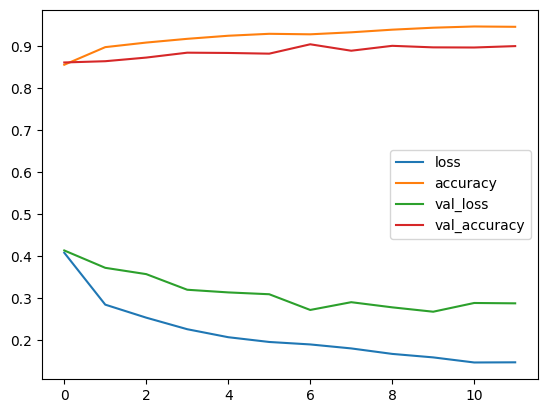

In [5]:
pd.DataFrame(model.history.history).plot()

In [6]:
loss, accuracy = model.evaluate(test_gen)

24/24 [==============================] - 59s 2s/step - loss: 0.2954 - accuracy: 0.8970


<a id="part5"></a>
## Evaluate Final Model
Let us employ the final model we have generated for evaluation. Firstly, we can observe that the accuracy approaches approximately 90%.

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen_new = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=False  
)
y_pred = model.predict(test_gen_new)
y_pred_label = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

acc = accuracy_score(y_true, y_pred_label)
print(f"Predicted accuracy: {acc}")

Found 3000 images belonging to 6 classes.
24/24 [==============================] - 48s 2s/step
Predicted accuracy: 0.915


**Next, we will visualize the evaluation results by constructing a confusion matrix. It can be noted that the model performs exceptionally well, with the only exception being its slight difficulty in distinguishing between 'mountain' and 'glacier' categories compared to the other classifications**

Text(0.5, 1.0, 'Confusion Matrix')

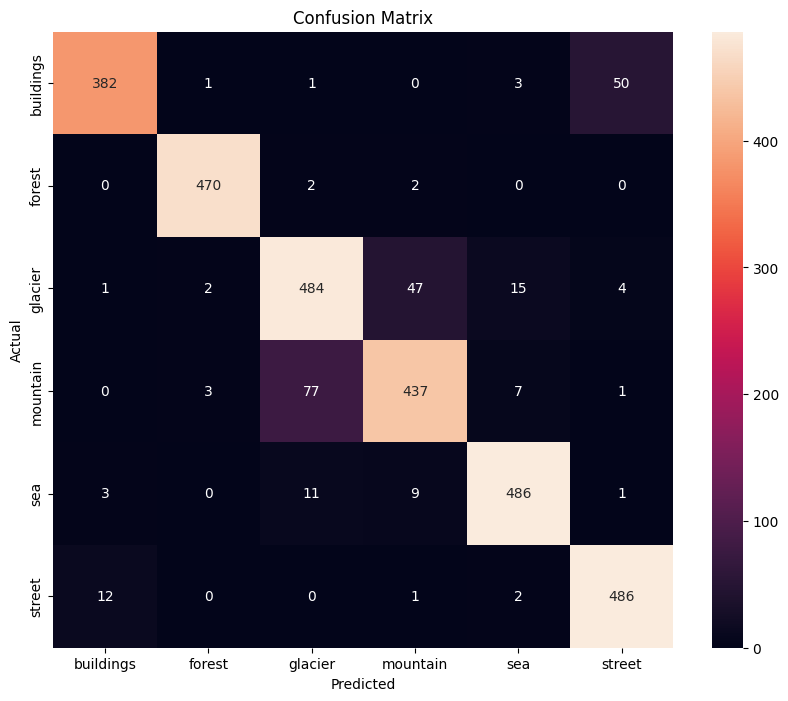

In [15]:
cm = confusion_matrix(y_true, y_pred_label)
class_names = list(train_gen.class_indices.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

**Next, let's visualize the model's performance. I will start by randomly selecting 16 images from our test dataset. It's evident that the model's predictions align with the actual images.**

1/1 [==============================] - 0s 39ms/step


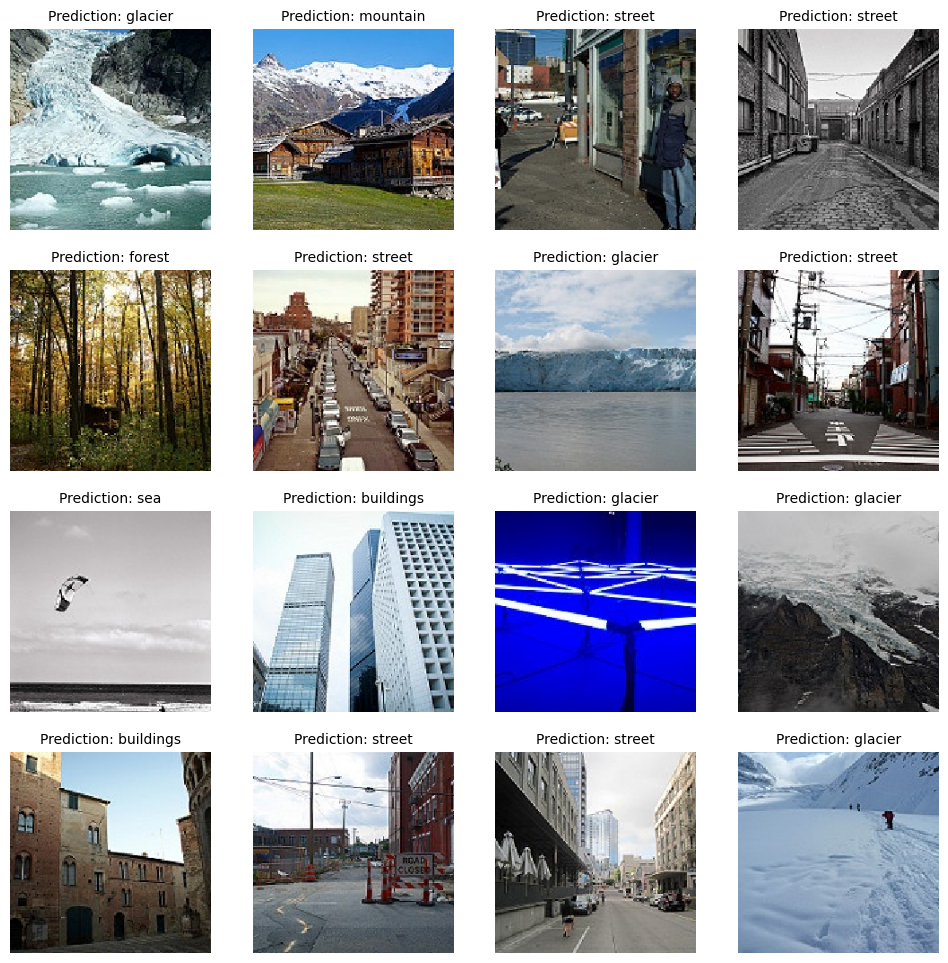

In [16]:
# plot test data image
mountain = [os.path.join(test_dict['mountain'], fname) for fname in os.listdir(test_dict['mountain'])]
sea = [os.path.join(test_dict['sea'], fname) for fname in os.listdir(test_dict['sea'])]
buildings = [os.path.join(test_dict['buildings'], fname) for fname in os.listdir(test_dict['buildings'])]
street = [os.path.join(test_dict['street'], fname) for fname in os.listdir(test_dict['street'])]
forest = [os.path.join(test_dict['forest'], fname) for fname in os.listdir(test_dict['forest'])]
glacier = [os.path.join(test_dict['glacier'], fname) for fname in os.listdir(test_dict['glacier'])]
pred_files = mountain + sea +buildings +street+ forest+glacier


random_indices = np.random.randint(0, len(pred_files), size=16)

# create plot 
fig, ax = plt.subplots(4, 4, figsize=(12, 12))


for i, ax in enumerate(ax.flat):
    random_n = random_indices[i]
    img_path = pred_files[random_n]
    
    # loading image and preprocessing
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    
    # predict the image
    pred = model.predict(img)
    pred = np.argmax(pred, axis=1)[0]  
    
    # create title of the image
    pred_label = class_names[pred]
        
    ax.imshow(img[0])
    ax.set_title(f"Prediction: {pred_label}", fontsize=10)
    ax.axis("off")


**Finally, we use this model to predict our validation data. Since this dataset is unlabeled, we can only assess the model's performance based on our judgment. The results are quite satisfactory, and the model's predictive ability is excellent**

1/1 [==============================] - 0s 41ms/step


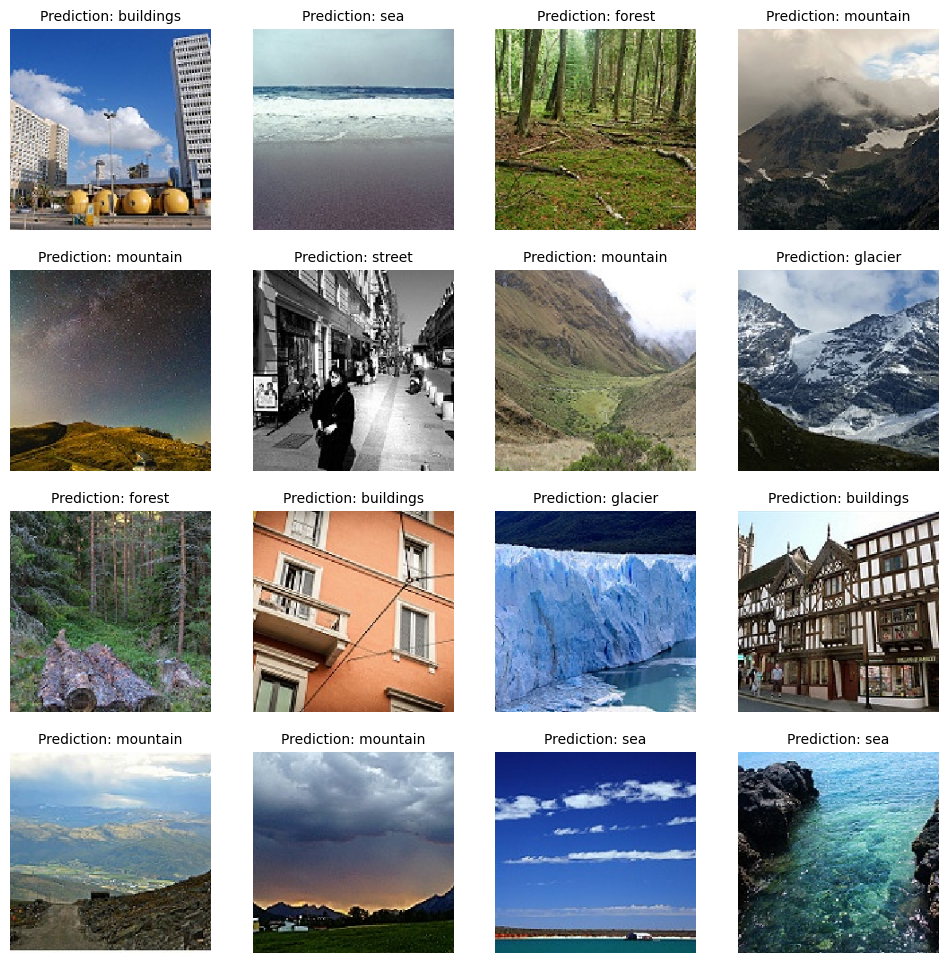

In [17]:
pred_folder = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'
pred_files = [os.path.join(pred_folder, f) for f in os.listdir(pred_folder)]
random_indices = np.random.randint(0, len(pred_files), size=16)

# create plot 
fig, ax = plt.subplots(4, 4, figsize=(12, 12))


for i, ax in enumerate(ax.flat):
    random_n = random_indices[i]
    img_path = pred_files[random_n]
    
    # loading image and preprocessing
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255
    img = np.expand_dims(img, axis=0)
    
    # predict the image
    pred = model.predict(img)
    pred = np.argmax(pred, axis=1)[0]  
    
    # create title of the image
    pred_label = class_names[pred]
        
    ax.imshow(img[0])
    ax.set_title(f"Prediction: {pred_label}", fontsize=10)
    ax.axis("off")


In [18]:
model.save('/kaggle/working/model.h5')

**Since the test dataset is labeled, we can attempt to identify what the misclassified images by the model look like**  
It's noticeable that these images are relatively blurry and mainly depict scenes like mountains, glaciers, and seas

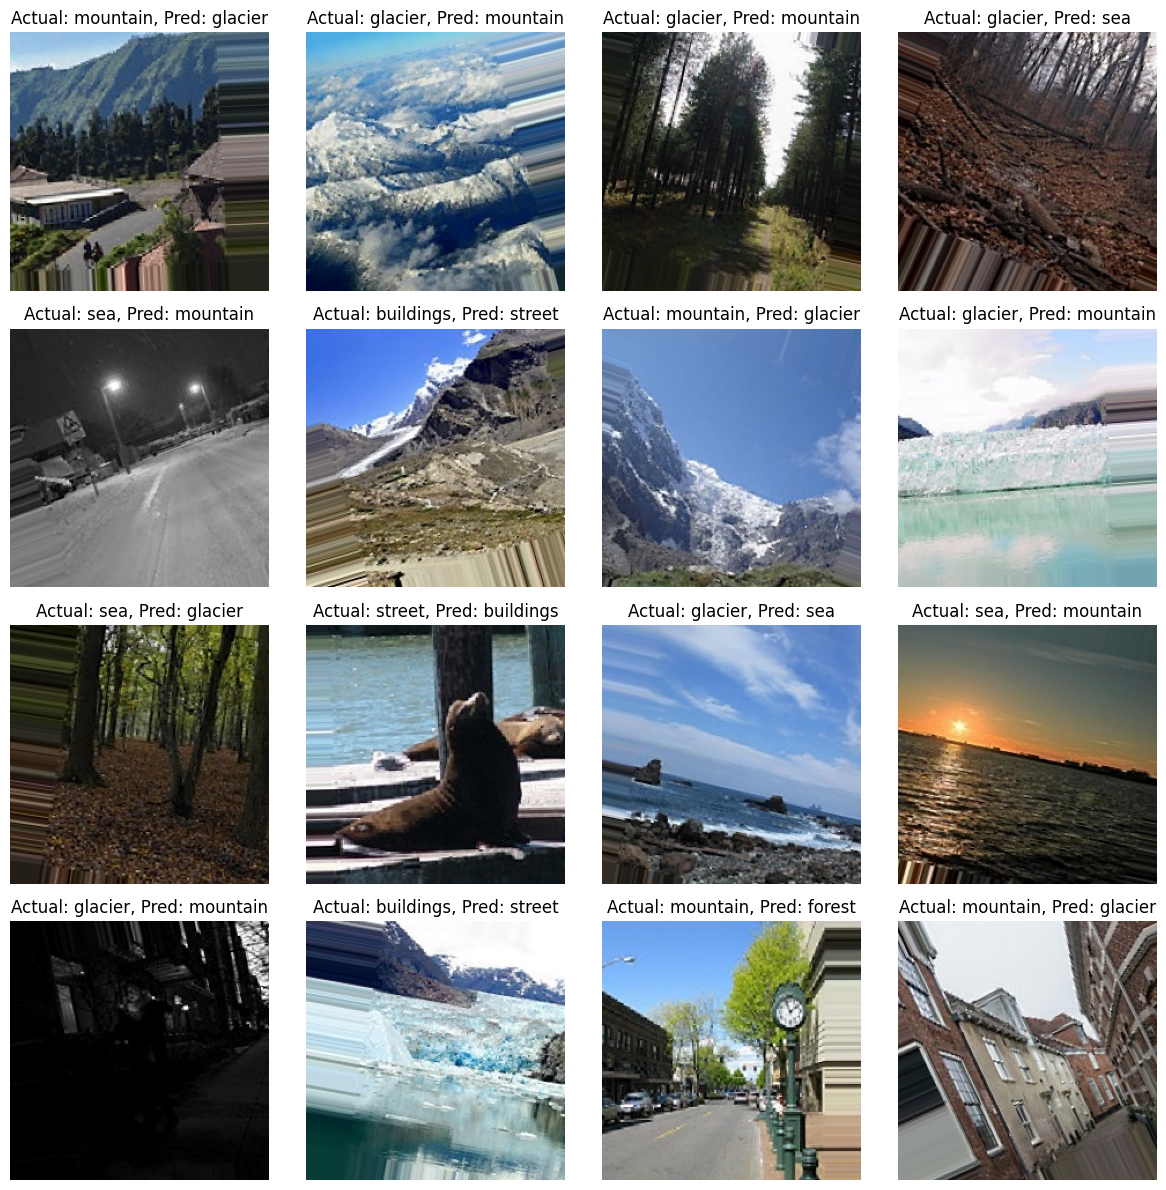

In [21]:
# find some incorrect image
incorrect_indices = np.nonzero(y_pred_label != y_true)[0]

if len(incorrect_indices) > 16:
    incorrect_indices = np.random.choice(incorrect_indices, 16, replace=False)

fig, ax = plt.subplots(4, 4, figsize=(12, 12))

for i, incorrect in enumerate(incorrect_indices):
    plt.subplot(4, 4, i + 1)
    
    img = test_gen[incorrect // batch_size][0][incorrect % batch_size]
    img = img * 255
    img = img.astype(np.uint8)
    
    plt.imshow(img)
    plt.title(f"Actual: {class_names[y_true[incorrect]]}, Pred: {class_names[y_pred_label[incorrect]]}")
    plt.axis("off")

plt.tight_layout()
